## Building our own classification model

In this notebook, we will create a classification model to help Perpetual Investors get a insightful environmental and social information about the pilot companies. The goal is to help them make data-drive decision about wether they should invest in these companies. The classification model will assign the companies in three different categories regarding their Environmental Actions: 

1) Good Forecasting
2) Improving
3) Bad forecasting

Further on the notebook, we will get into more detail about the requried 'rules' for each classification group. 

As mentioned, we are doing this classification model for the 52 US pilot stocks. Moreover, because we know how important the industry factor is, we decided to classify the companies within each industry to make them comparable. Therefore, we will have two classification model. One to classify the companies in the Utility industry and another for the Energy industry. 

Steps followed to build our own classificaiton model:
 
1) Data Cleaning
2) Hierarchical Clustering
3) K-Means Clustering
4) Cluster Profiling
5) Assigned the labels based in the final clusters and rules

We will have a Hierachical Clustering and K-means clustering for each industry. We used Unsupervised Machine Learning to find patterns and similirities within the companies. 


Let's start building the model. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for distance and h-clustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

#Kmeans clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics 
from sklearn.decomposition import PCA

# sklearn does have some functionality too, but mostly a wrapper to scipy
from sklearn.metrics import pairwise_distances 
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('df_merged.csv')
df_ei = pd.read_csv('/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/Environmental_impact_cleaned.csv')
stocks = pd.read_csv('/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/pilot_stocks.csv')

In [2]:
sectors = pd.read_csv("/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/52_tickers_sectors.csv")
stocks['Missing_GHG'] = np.where(stocks['GHG Scope 1'].isna(), 1, 0)
df = pd.merge(stocks, sectors, how='inner',on='Ticker')
df.drop(columns='Name', inplace=True)
stocks = df.copy()
stocks['Utility'] = np.where(stocks.Sector == 'Utilities',1,0)
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 0 to 779
Data columns (total 28 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Year                                               780 non-null    int64  
 1   Ticker                                             780 non-null    object 
 2   Environmental Disclosure Score                     636 non-null    float64
 3   GHG Scope 1                                        398 non-null    float64
 4   Total Energy Consumption                           243 non-null    float64
 5   Change_in_EDS                                      589 non-null    float64
 6   Change_in_GHG                                      377 non-null    float64
 7   Change_in_TEC                                      237 non-null    float64
 8   Company                                            780 non-null    object 
 9   Total_Asse

## Data Cleaning - version 1

As presented throughout the project, industry plays a crudential factor when try to understand, interpret and predict the company environmental actions. In this version, we decided to impute the missing values using the industry average of that year.

At the end, we decided to not use this version. However, we want to present that it was part of our analysis. 

In [3]:
stocks_df = stocks.copy()
stocks_df = stocks_df.loc[:, ~stocks_df.columns.isin(['Logarithm_Total_Assets','Logarithm_Total_Sales','Sector','Missing_GHG'])]
stocks_df.loc[np.isinf(stocks_df.Annual_Stock_Return),'Annual_Stock_Return'] = np.nan #We can see infinity values for PSX and FANG, we want null values instead

In [4]:
stocks_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,780.0,2012.000000,4.323266,2005.000000,2008.000000,2012.000000,2016.000000,2.019000e+03
Environmental Disclosure Score,636.0,31.469654,18.263954,1.400000,15.900000,31.750000,45.500000,8.430000e+01
GHG Scope 1,398.0,28308.354774,32606.231283,52.500000,5225.000000,15042.650000,36650.000000,1.455000e+05
Total Energy Consumption,243.0,138491.043210,308233.410807,101.500000,10630.400000,60000.000000,191643.500000,3.773309e+06
Change_in_EDS,589.0,25.285433,105.813056,-65.363128,0.000000,2.725724,19.090909,1.887500e+03
Change_in_GHG,377.0,-0.660034,26.811189,-87.928545,-8.586678,-1.145510,3.606484,2.408636e+02
Change_in_TEC,237.0,122.143943,1228.707439,-98.965689,-8.361044,0.000000,3.196347,1.575025e+04
Total_Assets,754.0,44006.135068,52446.876654,172.517000,17640.800500,30182.100000,47309.500000,3.625970e+05
Net_Income,754.0,1862.769263,5374.043089,-23119.000000,306.810750,827.396500,1830.750000,4.522000e+04
Total_Sales,754.0,27297.776397,56598.313351,27.253000,6639.350000,11485.987500,16794.000000,4.335260e+05


Let's impute null values with that year industry average for all the columns that contain null values. 

In [5]:
null_columns= stocks_df.columns[stocks_df.isnull().any()]
null_columns = null_columns.tolist()

for column in null_columns:
    stocks_df[column] = stocks_df.groupby(['Year','Utility']).transform('mean')[[column]]

In [6]:
stocks_df.isna().sum()

Year                                                   0
Ticker                                                 0
Environmental Disclosure Score                         0
GHG Scope 1                                           28
Total Energy Consumption                              56
Change_in_EDS                                         52
Change_in_GHG                                         80
Change_in_TEC                                        108
Company                                                0
Total_Assets                                           0
Net_Income                                             0
Total_Sales                                            0
Change_in_Sales                                        0
Change_in_Assets                                       0
Change_in_NI                                           0
ROA                                                    0
Profit_Margin                                          0
Annual_Stock_Return            

We have less null values now. However, we keep seeing a great amout of null values for the Annual Stock Return and Change in Total Energy Consumption. We are going to proceed to drop these columns and not consider them for the clustering analysis. 

In [7]:
stocks_df = stocks_df.loc[:, ~stocks_df.columns.isin(['Annual_Stock_Return','Change_in_TEC'])]
stocks_df.head()

,Year,Ticker,Environmental Disclosure Score,GHG Scope 1,Total Energy Consumption,Change_in_EDS,Change_in_GHG,Company,Total_Assets,Net_Income,...,Change_in_Assets,Change_in_NI,ROA,Profit_Margin,Ratio of GHG Emissions to Total Assets,Ratio of GHG Emissions to Total Sales,Ratio of Total Energy Consumption to Total Assets,Ratio of Total Energy Consumption to Total Sales,Profitable,Utility
0,2005,AEE,16.566667,NaN,NaN,NaN,NaN,AMEREN CORP,24071.876643,576.930357,...,0.000000,0.000000,2.026963,5.256459,NaN,NaN,NaN,NaN,True,1
1,2006,AEE,19.153846,23845.733333,NaN,33.294759,NaN,AMEREN CORP,25461.556893,743.487464,...,8.426933,131.125886,2.805735,7.315447,1385.834983,3562.017617,NaN,NaN,True,1
2,2007,AEE,18.677273,29858.580000,342779.0,49.676880,2.352400,AMEREN CORP,25310.003393,849.919000,...,1.692627,20.697883,3.061647,7.787263,1404.172783,3678.546329,6896.406728,26948.034591,True,1
3,2008,AEE,19.676923,23344.828571,327939.0,14.110217,-1.376797,AMEREN CORP,27335.062393,897.238429,...,8.712634,-56.068254,2.911754,7.297716,1125.808991,3072.642435,6178.551915,24830.695843,True,1
4,2009,AEE,26.074074,18867.840000,164566.8,117.994489,-8.848381,AMEREN CORP,28166.217107,793.816214,...,2.509002,-8.709084,2.529959,7.277938,862.327458,2568.875251,3531.590905,14210.128816,True,1


In [8]:
is_NaN = stocks_df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = stocks_df[row_has_NaN]
null_columns1= rows_with_NaN.columns[rows_with_NaN.isnull().any()]
null_columns1 = null_columns1.tolist()
null_columns1.append('Year')
rows_with_NaN[null_columns1]

,GHG Scope 1,Total Energy Consumption,Change_in_EDS,Change_in_GHG,Ratio of GHG Emissions to Total Assets,Ratio of GHG Emissions to Total Sales,Ratio of Total Energy Consumption to Total Assets,Ratio of Total Energy Consumption to Total Sales,Year
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005
1,23845.733333,NaN,33.294759,NaN,1385.834983,3562.017617,NaN,NaN,2006
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005
16,23845.733333,NaN,33.294759,NaN,1385.834983,3562.017617,NaN,NaN,2006
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005
...,...,...,...,...,...,...,...,...,...
721,23845.733333,NaN,33.294759,NaN,1385.834983,3562.017617,NaN,NaN,2006
735,11950.000000,74970.0,NaN,NaN,432.979753,410.866467,2630.710927,1279.43887,2005
750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005
751,23845.733333,NaN,33.294759,NaN,1385.834983,3562.017617,NaN,NaN,2006


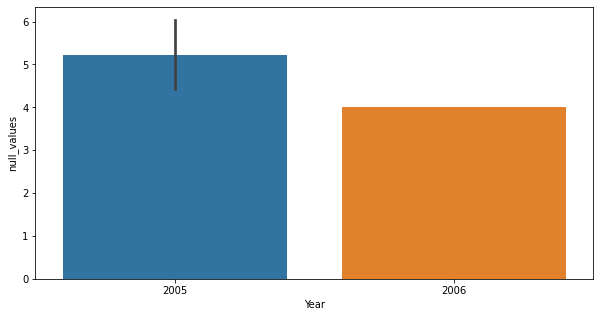

In [9]:
rows_with_NaN['null_values'] = rows_with_NaN.isnull().sum(axis=1)
rows_with_NaN.head()

plt.figure(figsize=(10,5));
sns.barplot(x='Year', y = 'null_values', data = rows_with_NaN);

Let's get rid of data from 2005 and 2006 because it is missing data for multiple columns

In [10]:
stocks_df = stocks_df.loc[stocks_df.Year >= 2007, ]
stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 676 entries, 2 to 779
Data columns (total 22 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Year                                               676 non-null    int64  
 1   Ticker                                             676 non-null    object 
 2   Environmental Disclosure Score                     676 non-null    float64
 3   GHG Scope 1                                        676 non-null    float64
 4   Total Energy Consumption                           676 non-null    float64
 5   Change_in_EDS                                      676 non-null    float64
 6   Change_in_GHG                                      676 non-null    float64
 7   Company                                            676 non-null    object 
 8   Total_Assets                                       676 non-null    float64
 9   Net_Income

## Hierarchical Clustering - version 1 and utility industry


Now that we have a cleaned dataset, we will start with the clustering. First, we did Hierarchical Clustering for the utility industry. 

*As a reminder, we are not using this version for the classification model.*

In [11]:
# 1) Standarized the data
df = stocks_df[stocks_df.Utility == 1]
stock_number = df.select_dtypes('number')
sc = StandardScaler()
stock_scaled = sc.fit_transform(stock_number)
stock_scaled = pd.DataFrame(stock_scaled, columns = stock_number.columns)
stock_scaled

,Year,Environmental Disclosure Score,GHG Scope 1,Total Energy Consumption,Change_in_EDS,Change_in_GHG,Total_Assets,Net_Income,Total_Sales,Change_in_Sales,Change_in_Assets,Change_in_NI,ROA,Profit_Margin,Ratio of GHG Emissions to Total Assets,Ratio of GHG Emissions to Total Sales,Ratio of Total Energy Consumption to Total Assets,Ratio of Total Energy Consumption to Total Sales,Utility
0,-1.603567,-1.626588,-0.009989,0.715048,0.879926,0.668179,-1.458084,-0.330097,-1.326754,0.159045,-1.453307,0.684226,0.870115,-0.563975,2.527845,2.088422,0.946634,1.005670,0.0
1,-1.336306,-1.514224,-1.193930,0.629004,-0.332286,0.104514,-1.222410,-0.136021,-0.150339,1.239264,0.834970,-0.595059,0.632709,-0.812023,1.130007,0.232361,0.704585,0.816821,0.0
2,-1.069045,-0.795163,-2.007669,-0.318249,3.208382,-1.024811,-1.125682,-0.560196,-1.738446,-2.124068,-1.187198,0.194167,0.028010,-0.822045,-0.193098,-1.310826,-0.187930,-0.130444,0.0
3,-0.801784,-0.724807,-1.137553,-0.395566,-0.466368,0.551322,-0.925449,-0.185963,-1.045936,0.495354,0.048584,0.689179,0.471582,-0.141647,0.409959,0.228368,-0.483058,-0.446022,0.0
4,-0.534522,-0.552455,0.729316,0.091868,-0.289423,-0.024700,-0.641432,0.017768,-0.567129,0.234041,0.533778,1.038921,0.587068,0.141892,0.607740,1.419485,0.481726,0.342604,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,0.534522,0.528282,0.776012,-0.483558,-0.065203,-1.027699,0.385752,-0.817127,0.425876,-1.603180,-0.732643,-2.660704,-1.540464,-0.734736,-0.274591,0.272423,-0.462931,-0.623333,0.0
360,0.801784,0.877982,0.295243,-0.648703,-0.146088,-0.936210,0.808715,-1.260166,0.253713,-0.544833,0.208258,-0.522049,-1.630072,-0.670751,-0.737035,-0.426372,-0.869843,-0.799151,0.0
361,1.069045,1.241836,-0.314184,-0.734232,-0.264208,-0.261941,0.972987,0.291251,0.707892,0.079311,-0.934880,0.769087,-0.914361,0.200789,-1.046394,-1.039170,-0.690130,-0.698572,0.0
362,1.336306,1.275571,0.025056,-0.657463,-0.711375,-0.243917,1.285979,1.458217,1.261293,0.713624,0.763994,0.319088,0.268307,1.500906,-0.656664,-0.621066,-0.463070,-0.634542,0.0


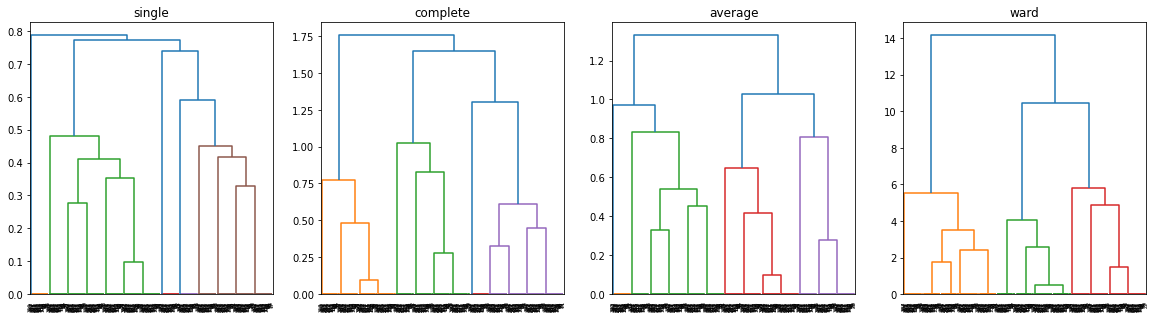

In [12]:
#2) Clustering using euclidean and cosine for distance matrix

dc1 = pdist(stock_scaled.values) #euclidean
dc2 = pdist(stock_scaled.values, metric='cosine')

#See now with linkage method and cosine distance matrix work
METHODS = ['single', 'complete', 'average', 'ward']

plt.figure(figsize=(20,5))

for i,m in enumerate(METHODS):
    plt.subplot(1,4,i+1)
    plt.title(m)
    dendrogram(linkage(dc2, method=m),
                leaf_rotation= 90)

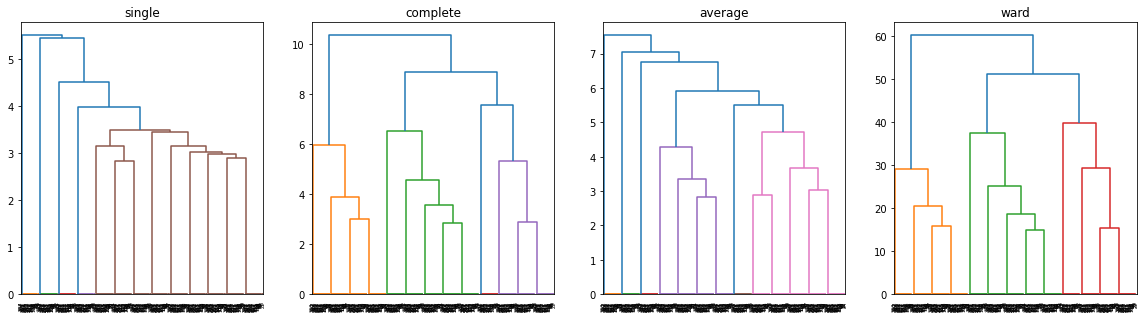

In [13]:
#3 ) See how linkage method and euclidean distance metric work
plt.figure(figsize=(20,5))

for i,m in enumerate(METHODS):
    plt.subplot(1,4,i+1)
    plt.title(m)
    dendrogram(linkage(dc1, method=m),
                leaf_rotation= 90)

I am going to use the cosine and average because the cluster start forming lower and there isnt too much height compared to the other methods. Clusters are more group together and compact 

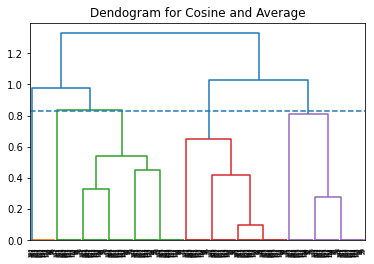

In [14]:
#4) Create the labels
hc1 = linkage(dc2, method='average')
plt.title('Dendogram for Cosine and Average')
dendrogram(hc1,
            leaf_rotation= 90)
plt.axhline(linestyle='--', y=.83)

In [15]:
labels = fcluster(hc1, 3, criterion='maxclust')
np.unique(labels)

array([1, 2, 3], dtype=int32)

In [16]:
#put the labels into the clean dataset
df['cluster'] = labels
df.head(3) #Review the dataset with the labels

,Year,Ticker,Environmental Disclosure Score,GHG Scope 1,Total Energy Consumption,Change_in_EDS,Change_in_GHG,Company,Total_Assets,Net_Income,...,Change_in_NI,ROA,Profit_Margin,Ratio of GHG Emissions to Total Assets,Ratio of GHG Emissions to Total Sales,Ratio of Total Energy Consumption to Total Assets,Ratio of Total Energy Consumption to Total Sales,Profitable,Utility,cluster
2,2007,AEE,18.677273,29858.580000,342779.0,49.676880,2.352400,AMEREN CORP,25310.003393,849.919000,...,20.697883,3.061647,7.787263,1404.172783,3678.546329,6896.406728,26948.034591,True,1,1
3,2008,AEE,19.676923,23344.828571,327939.0,14.110217,-1.376797,AMEREN CORP,27335.062393,897.238429,...,-56.068254,2.911754,7.297716,1125.808991,3072.642435,6178.551915,24830.695843,True,1,1
4,2009,AEE,26.074074,18867.840000,164566.8,117.994489,-8.848381,AMEREN CORP,28166.217107,793.816214,...,-8.709084,2.529959,7.277938,862.327458,2568.875251,3531.590905,14210.128816,True,1,1


In [17]:
#How many stocks per cluster
df.cluster.value_counts(dropna=False, sort=False)

1    168
2    112
3     84
Name: cluster, dtype: int64

When using three clusters... we can see that the number of observations are more balanced. 

[Text(0.5, 1.0, 'Stock - Hierarchical Clustering')]

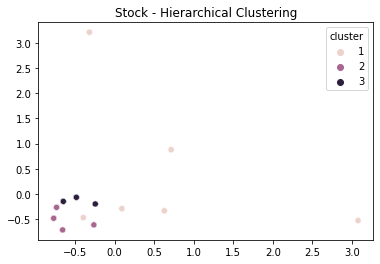

In [18]:
X = stock_scaled.values
sns.scatterplot(X[:,3],X[:,4],hue=df.cluster, cmap="rainbow").set(title='Stock - Hierarchical Clustering')

### K-Means Clustering - version 1 and utility

<AxesSubplot:>

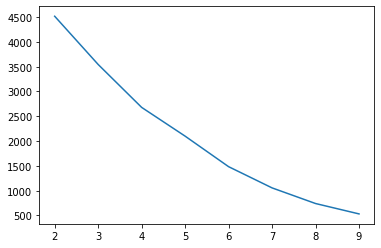

In [19]:
#Cluster Evaluation - Deciding how many clusters
X = stock_scaled.values
KRANGE = range(2,10)
sse = []

## loop over and evaluate
for k in KRANGE:
  km = KMeans(k)
  labs = km.fit_predict(stock_scaled)
  sse.append(km.inertia_)

#Elbow Method
sns.lineplot(KRANGE,sse)

<AxesSubplot:>

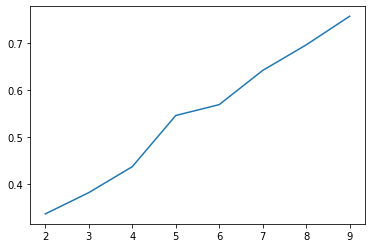

In [20]:
# Testing K
ss1 = []

for k in KRANGE:
  km = KMeans(k)
  lab = km.fit_predict(stock_scaled)
  ss1.append(metrics.silhouette_score(stock_scaled, lab))

sns.lineplot(KRANGE, ss1)

In [21]:
#It shows 3 clusters are the best option... because it radically descreases when 4.

##K Means for 3
k3 = KMeans(3)
k3.fit(X)
k3_labs = k3.predict(X)

In [22]:
df['k3'] = k3_labs
df.k3.value_counts(dropna=False, sort=False) #

0    112
1    168
2     84
Name: k3, dtype: int64

## Hierarchical Clustering - version 1 and Energy industry

In [23]:
# 1) Standarized the data
df1 = stocks_df[stocks_df.Utility == 0]
stock_number = df1.select_dtypes('number')
sc = StandardScaler()
stock_scaled = sc.fit_transform(stock_number)
stock_scaled = pd.DataFrame(stock_scaled, columns = stock_number.columns)
stock_scaled

,Year,Environmental Disclosure Score,GHG Scope 1,Total Energy Consumption,Change_in_EDS,Change_in_GHG,Total_Assets,Net_Income,Total_Sales,Change_in_Sales,Change_in_Assets,Change_in_NI,ROA,Profit_Margin,Ratio of GHG Emissions to Total Assets,Ratio of GHG Emissions to Total Sales,Ratio of Total Energy Consumption to Total Assets,Ratio of Total Energy Consumption to Total Sales,Utility
0,-1.603567,-1.180250,2.444606,0.382461,0.318353,-0.263506,-1.404091,1.184593,0.380220,0.029446,1.088644,0.269546,1.439974,0.919825,0.426930,-0.597891,0.128905,-0.724833,0.0
1,-1.336306,-0.983208,1.642062,3.386287,2.049795,-0.406269,-1.690471,0.365668,1.450673,0.952673,-0.021302,-0.312066,0.535372,0.385365,3.242348,2.682054,3.423615,2.475247,0.0
2,-1.069045,-0.778242,0.418996,-0.190871,-0.346212,-2.034185,-1.619526,-0.384349,-0.570848,-1.745498,-0.349969,-0.212872,-0.085318,0.138236,0.391257,0.666595,-0.283829,-0.291885,0.0
3,-0.801784,-0.821406,0.304061,-0.254163,-0.784159,-1.471398,-0.776502,0.445092,0.411619,0.703970,0.633779,-0.446889,0.423403,0.657284,-0.424059,-0.918502,-0.324905,-0.989986,0.0
4,-0.534522,-0.372013,-0.061599,-0.247434,-0.018908,1.437836,-0.150424,1.210522,1.532144,0.989166,1.056769,0.434631,0.857627,0.757514,-0.276915,-0.970235,-0.451623,-1.278427,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0.534522,0.178634,-0.318692,-0.370579,-0.282827,-0.167982,0.497317,-1.912827,-1.186175,-1.966148,-2.407592,-0.921277,-2.452211,-2.756061,-0.108175,0.296540,-0.359072,0.167611,0.0
308,0.801784,0.685560,-0.541348,-0.381446,2.085182,-0.633487,0.344429,-1.684325,-1.698863,-1.077143,-0.643113,0.350522,-1.410616,-1.506164,0.025834,1.199670,-0.080925,1.477101,0.0
309,1.069045,1.083076,-1.029470,-0.432682,0.057406,-0.027990,0.332229,-0.570472,-1.194253,1.196264,-0.869169,-0.961575,-0.331796,-0.230582,-0.377196,0.155720,-0.182079,0.463443,0.0
310,1.336306,1.386493,-1.093107,-0.495630,-0.987165,1.327237,0.587770,0.079518,-0.521884,0.914092,0.011192,-0.213550,0.411633,0.563055,-0.527094,-0.380951,-0.356632,0.132007,0.0


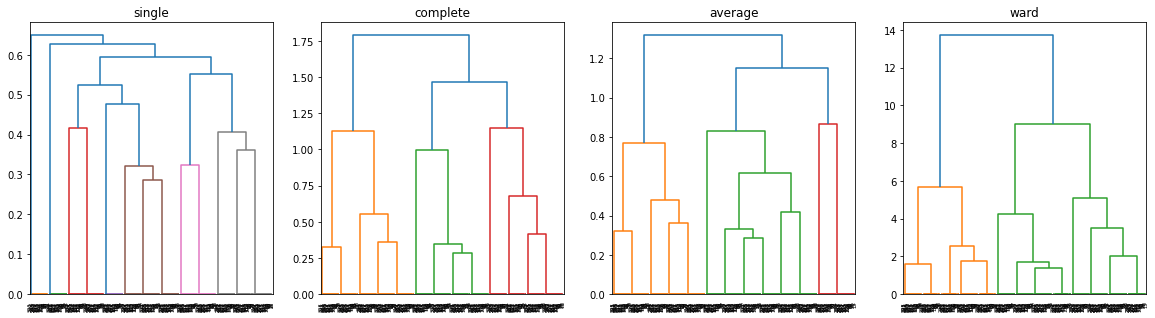

In [24]:
#2) Clustering using euclidean and cosine for distance matrix

dc1 = pdist(stock_scaled.values) #euclidean
dc2 = pdist(stock_scaled.values, metric='cosine')

#See now with linkage method and cosine distance matrix work
METHODS = ['single', 'complete', 'average', 'ward']

plt.figure(figsize=(20,5))

for i,m in enumerate(METHODS):
    plt.subplot(1,4,i+1)
    plt.title(m)
    dendrogram(linkage(dc2, method=m),
                leaf_rotation= 90)

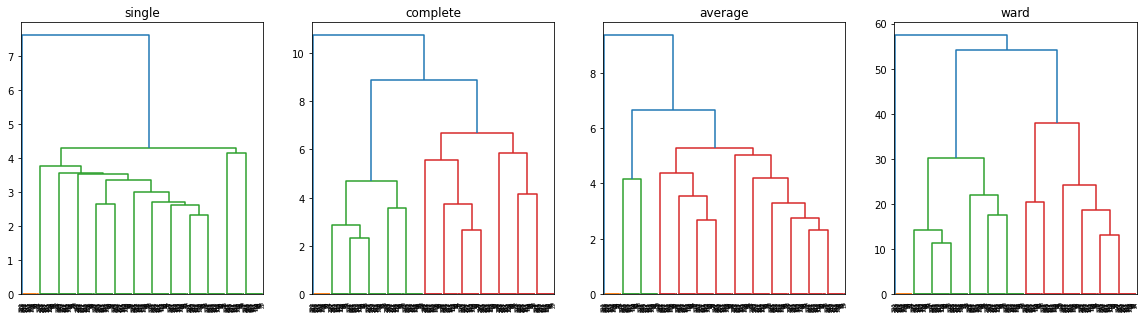

In [25]:
#3 ) See how linkage method and euclidean distance metric work
plt.figure(figsize=(20,5))

for i,m in enumerate(METHODS):
    plt.subplot(1,4,i+1)
    plt.title(m)
    dendrogram(linkage(dc1, method=m),
                leaf_rotation= 90)

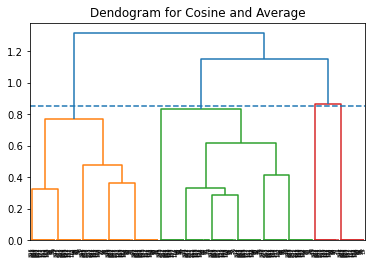

In [26]:
#4) Create the labels
hc1 = linkage(dc2, method='average')
plt.title('Dendogram for Cosine and Average')
dendrogram(hc1,
            leaf_rotation= 90)
plt.axhline(linestyle='--', y=.85)

In [27]:
labels = fcluster(hc1, 2, criterion='maxclust')
np.unique(labels)

array([1, 2], dtype=int32)

In [28]:
#put the labels into the clean dataset
df1['cluster'] = labels
df1.head(3) #Review the dataset with the labels

,Year,Ticker,Environmental Disclosure Score,GHG Scope 1,Total Energy Consumption,Change_in_EDS,Change_in_GHG,Company,Total_Assets,Net_Income,...,Change_in_NI,ROA,Profit_Margin,Ratio of GHG Emissions to Total Assets,Ratio of GHG Emissions to Total Sales,Ratio of Total Energy Consumption to Total Assets,Ratio of Total Energy Consumption to Total Sales,Profitable,Utility,cluster
47,2007,APA,21.006667,47991.866667,201411.920000,36.438206,-1.411253,APACHE CORP,47428.339600,5389.921400,...,32.128579,10.212219,14.338186,337.329899,354.686625,1362.496196,1067.987067,True,0,2
48,2008,APA,22.381250,41021.480000,633597.340000,72.142628,-2.624571,APACHE CORP,45742.297850,3649.938250,...,-72.062911,5.700466,7.181909,681.797923,985.682727,4440.540036,2784.659698,True,0,2
49,2009,APA,23.811111,30398.720000,118921.842857,22.734085,-16.460037,APACHE CORP,46159.977238,2056.365095,...,-54.292946,2.604742,3.872914,332.965177,597.948466,976.903505,1300.240317,False,0,2


In [29]:
#How many stocks per cluster
df1.cluster.value_counts(dropna=False, sort=False)

1    120
2    192
Name: cluster, dtype: int64

## K-Means version 1 and energy industry

<AxesSubplot:>

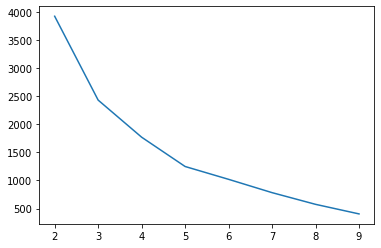

In [30]:
#Cluster Evaluation - Deciding how many clusters
X = stock_scaled.values
KRANGE = range(2,10)
sse = []

## loop over and evaluate
for k in KRANGE:
  km = KMeans(k)
  labs = km.fit_predict(stock_scaled)
  sse.append(km.inertia_)

#Elbow Method
sns.lineplot(KRANGE,sse)

<AxesSubplot:>

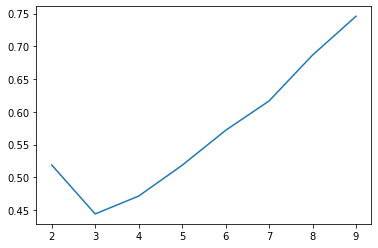

In [31]:
# Testing K
ss1 = []

for k in KRANGE:
  km = KMeans(k)
  lab = km.fit_predict(stock_scaled)
  ss1.append(metrics.silhouette_score(stock_scaled, lab))

sns.lineplot(KRANGE, ss1)

In [32]:
#It shows 2 clusters are the best option... because it radically descreases when 4.

##K Means for 2
k2 = KMeans(2)
k2.fit(X)
k2_labs = k2.predict(X)

In [34]:
df1['k2'] = k2_labs
df1.k2.value_counts(dropna=False, sort=False) #

0    288
1     24
Name: k2, dtype: int64

## Cluster profiling for Utility industry

In [35]:
df_clus = df.drop(columns=['k3','Utility'])
stock_numeric = df_clus.select_dtypes('number')
stock_numeric

,Year,Environmental Disclosure Score,GHG Scope 1,Total Energy Consumption,Change_in_EDS,Change_in_GHG,Total_Assets,Net_Income,Total_Sales,Change_in_Sales,Change_in_Assets,Change_in_NI,ROA,Profit_Margin,Ratio of GHG Emissions to Total Assets,Ratio of GHG Emissions to Total Sales,Ratio of Total Energy Consumption to Total Assets,Ratio of Total Energy Consumption to Total Sales,cluster
2,2007,18.677273,29858.580000,342779.000000,49.676880,2.352400,25310.003393,849.919000,9606.342643,2.646577,1.692627,20.697883,3.061647,7.787263,1404.172783,3678.546329,6896.406728,26948.034591,1
3,2008,19.676923,23344.828571,327939.000000,14.110217,-1.376797,27335.062393,897.238429,10370.114714,8.094511,8.712634,-56.068254,2.911754,7.297716,1125.808991,3072.642435,6178.551915,24830.695843,1
4,2009,26.074074,18867.840000,164566.800000,117.994489,-8.848381,28166.217107,793.816214,9339.057071,-8.867982,2.509002,-8.709084,2.529959,7.277938,862.327458,2568.875251,3531.590905,14210.128816,1
5,2010,26.700000,23655.000000,151232.066667,10.176206,1.579278,29886.748250,885.061679,9788.659786,4.342708,6.300149,20.995137,2.810021,8.620769,982.419448,3071.338888,2656.319648,10671.932479,1
6,2011,28.233333,33926.050000,235299.600000,15.367831,-2.231674,32327.204107,934.735250,10099.519286,3.024810,7.788635,41.982113,2.882937,9.180360,1021.805361,3460.174545,5517.613464,19513.863585,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,2015,37.848148,34182.959091,136056.161538,21.946524,-8.867489,41153.442643,731.171321,10744.214536,-6.240956,3.903492,-180.021565,1.539656,7.450250,846.099025,3085.720464,2716.009764,8683.945953,3
761,2016,40.959259,31537.887500,107573.650000,19.573316,-8.262200,44787.810714,623.149750,10632.439714,-0.903328,6.790000,-51.687127,1.483079,7.576530,754.008501,2857.601783,1509.216402,6712.712161,3
762,2017,44.196296,28184.976000,92822.446667,16.107659,-3.801250,46199.345750,1001.415929,10927.309536,2.244454,3.283066,25.790159,1.934965,9.296599,692.403121,2657.556288,2042.196911,7840.383807,2
763,2018,44.496429,30051.388889,106062.837500,2.987642,-3.682008,48888.773607,1285.945214,11286.598071,5.443523,8.494892,-1.212929,2.681678,11.862507,770.013367,2794.044669,2715.598309,8558.278921,2


In [36]:
clus_profile = stock_numeric.groupby("cluster").mean()
clus_profile

,Year,Environmental Disclosure Score,GHG Scope 1,Total Energy Consumption,Change_in_EDS,Change_in_GHG,Total_Assets,Net_Income,Total_Sales,Change_in_Sales,Change_in_Assets,Change_in_NI,ROA,Profit_Margin,Ratio of GHG Emissions to Total Assets,Ratio of GHG Emissions to Total Sales,Ratio of Total Energy Consumption to Total Assets,Ratio of Total Energy Consumption to Total Sales
cluster,,,,,,,,,,,,,,,,,,
1,2009.666667,25.344218,27882.777540,328710.813889,35.961816,-1.020104,30076.236827,868.060476,9959.142786,2.550394,4.815862,-2.921694,2.760157,8.099854,1057.091881,3189.083511,6224.580092,23929.371582
2,2017.000000,42.386839,31232.514198,114918.547257,8.697172,-4.941242,47201.197938,1211.610027,11239.294679,4.400727,7.207944,18.420100,2.777771,11.172361,756.520534,2758.066796,2246.450464,8100.069256
3,2014.333333,36.438272,32216.413308,140325.737179,19.871690,-0.333919,40880.757940,680.145893,10456.108976,-2.975770,7.412461,-106.945546,1.662512,7.471875,780.505238,2930.496835,2274.314425,9255.963444


<AxesSubplot:xlabel='cluster'>

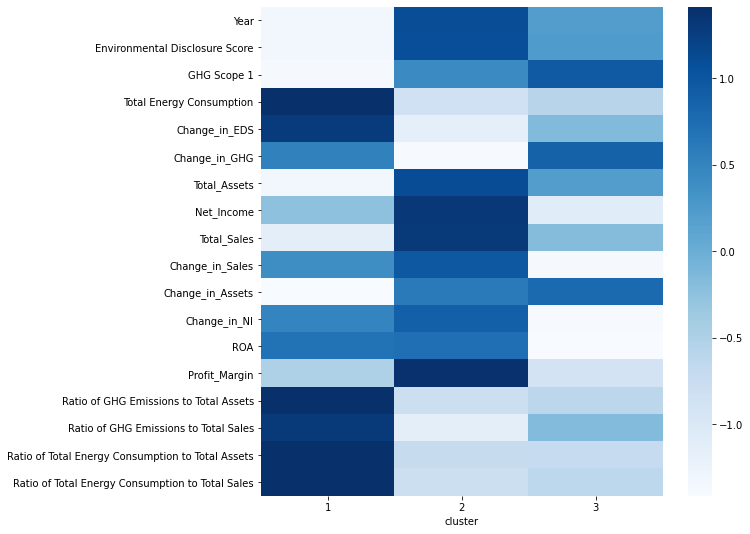

In [37]:
scp = StandardScaler()
cluster_scaled = scp.fit_transform(clus_profile)
cluster_scaled = pd.DataFrame(cluster_scaled, index=clus_profile.index, columns=clus_profile.columns)
plt.figure(figsize=(9,9))
sns.heatmap(cluster_scaled.T, cmap="Blues", center=0)

## Cluster profiling for Energy industry

In [38]:
df_clus = df1.drop(columns=['cluster','Utility'])
stock_numeric = df_clus.select_dtypes('number')
stock_numeric

,Year,Environmental Disclosure Score,GHG Scope 1,Total Energy Consumption,Change_in_EDS,Change_in_GHG,Total_Assets,Net_Income,Total_Sales,Change_in_Sales,Change_in_Assets,Change_in_NI,ROA,Profit_Margin,Ratio of GHG Emissions to Total Assets,Ratio of GHG Emissions to Total Sales,Ratio of Total Energy Consumption to Total Assets,Ratio of Total Energy Consumption to Total Sales,k2
47,2007,21.006667,47991.866667,201411.920000,36.438206,-1.411253,47428.339600,5389.921400,53283.519150,7.142204,16.635780,32.128579,10.212219,14.338186,337.329899,354.686625,1362.496196,1067.987067,0
48,2008,22.381250,41021.480000,633597.340000,72.142628,-2.624571,45742.297850,3649.938250,65747.774900,25.254215,8.708006,-72.062911,5.700466,7.181909,681.797923,985.682727,4440.540036,2784.659698,1
49,2009,23.811111,30398.720000,118921.842857,22.734085,-16.460037,46159.977238,2056.365095,42209.385286,-27.678908,6.360506,-54.292946,2.604742,3.872914,332.965177,597.948466,976.903505,1300.240317,0
50,2010,23.510000,29400.470000,109815.550000,13.703086,-11.676973,51123.226304,3818.690130,53649.131391,20.375111,13.386910,-96.215292,5.142014,10.822836,233.210873,293.007408,938.529190,925.746248,0
51,2011,26.645000,26224.576923,110783.700000,29.483484,13.048245,54809.214130,5445.012609,66696.417739,25.970125,16.408112,61.702311,7.307732,12.164886,251.213999,283.054941,820.143899,771.013135,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,2015,30.486364,23991.630769,93065.791667,24.041154,-0.599407,58622.744870,-1191.216609,35044.578043,-32.007642,-8.336026,-181.198459,-9.200268,-34.880928,271.859503,526.757191,906.609255,1546.735637,0
776,2016,34.022727,22057.786667,91502.346154,72.872346,-4.555677,57722.630217,-705.714348,29074.887957,-14.567025,4.266732,46.634802,-4.005254,-18.145155,288.255523,700.501562,1166.464382,2249.207475,0
777,2017,36.795833,17818.272222,84130.535714,31.057173,0.590373,57650.799917,1660.907042,34950.510083,30.033004,2.652134,-188.417454,1.375422,-1.065455,238.944507,499.666242,1071.963019,1705.433734,0
778,2018,38.912500,17265.568421,75073.717647,9.516871,12.108277,59155.281750,3041.950750,42779.515333,24.497328,8.940099,-54.414493,5.083314,9.561128,220.604421,396.421461,908.888266,1527.636113,0


In [39]:
clus_profile = stock_numeric.groupby("k2").mean()
clus_profile

,Year,Environmental Disclosure Score,GHG Scope 1,Total Energy Consumption,Change_in_EDS,Change_in_GHG,Total_Assets,Net_Income,Total_Sales,Change_in_Sales,Change_in_Assets,Change_in_NI,ROA,Profit_Margin,Ratio of GHG Emissions to Total Assets,Ratio of GHG Emissions to Total Sales,Ratio of Total Energy Consumption to Total Assets,Ratio of Total Energy Consumption to Total Sales
k2,,,,,,,,,,,,,,,,,,
0,2013.416667,29.811778,25571.097105,105782.987942,26.350958,1.115991,56524.20299,2808.251868,47448.655101,5.007057,8.872836,-11.499894,2.807754,1.591983,252.036116,426.711046,975.528397,1346.167995
1,2008.000000,22.381250,41021.480000,633597.340000,72.142628,-2.624571,45742.29785,3649.938250,65747.774900,25.254215,8.708006,-72.062911,5.700466,7.181909,681.797923,985.682727,4440.540036,2784.659698


<AxesSubplot:xlabel='k2'>

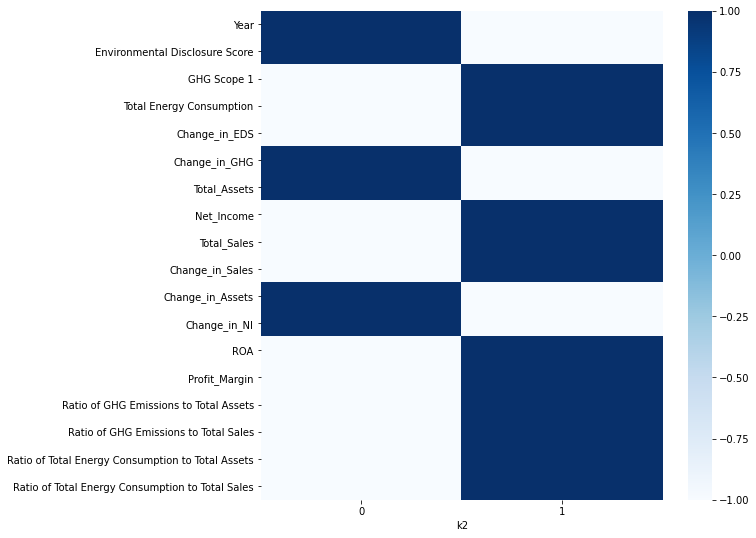

In [40]:
scp = StandardScaler()
cluster_scaled = scp.fit_transform(clus_profile)
cluster_scaled = pd.DataFrame(cluster_scaled, index=clus_profile.index, columns=clus_profile.columns)
plt.figure(figsize=(9,9))
sns.heatmap(cluster_scaled.T, cmap="Blues", center=0)

## Data Cleaning - version 2

We decided to not consider the first data cleaning version for the cluster analysis. Our second and final version consists and just using the companies that are not missing values for the GHG Scope 1. We decided to do this to be consistent with the predicitve models that were build in Sprint #4 . As a reminder, in that sprint, we build multiple models to predict the GHG Scope 1 and we only used the observations that didn't have null values. 

After subseting for the companies that have GHG Scope data, we collected the unique tickers and calculate the average for the features that we are instered to cluster by. For this version, we are going to consider the features GHG Scope 1, Total Assets and Total Sales. Our goal is to be able to find patterns, similarities and groups for these stocks.


In [41]:
stocks_clean = stocks.copy()
stocks_clean['time_trend'] = stocks_clean.groupby('Ticker').cumcount()
stocks_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 0 to 779
Data columns (total 29 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Year                                               780 non-null    int64  
 1   Ticker                                             780 non-null    object 
 2   Environmental Disclosure Score                     636 non-null    float64
 3   GHG Scope 1                                        398 non-null    float64
 4   Total Energy Consumption                           243 non-null    float64
 5   Change_in_EDS                                      589 non-null    float64
 6   Change_in_GHG                                      377 non-null    float64
 7   Change_in_TEC                                      237 non-null    float64
 8   Company                                            780 non-null    object 
 9   Total_Asse

In [42]:
stocks_clean = stocks_clean.loc[stocks_clean['Missing_GHG'] == 0, stocks_clean.columns.isin(['Company','GHG Scope 1','Total_Assets','Total_Sales','Utility'])]
stocks_clean

,GHG Scope 1,Company,Total_Assets,Total_Sales,Utility
8,32978.0,AMEREN CORP,21042.0,5838.0,1
9,30675.0,AMEREN CORP,22676.0,6053.0,1
10,28548.2,AMEREN CORP,23640.0,6098.0,1
11,26795.6,AMEREN CORP,24699.0,6076.0,1
12,30200.4,AMEREN CORP,25945.0,6177.0,1
...,...,...,...,...,...
775,118000.0,EXXON MOBIL CORP,336758.0,236810.0,0
776,120000.0,EXXON MOBIL CORP,330314.0,197518.0,0
777,117000.0,EXXON MOBIL CORP,348691.0,237162.0,0
778,119000.0,EXXON MOBIL CORP,346196.0,279332.0,0


In [43]:
agg = stocks_clean.groupby('Company')[['GHG Scope 1','Total_Assets','Total_Sales']].mean().reset_index()
stocks_cleaned = pd.merge(agg, stocks_clean, on='Company', how = 'inner',suffixes=('', '_drop'))
stocks_cleaned.drop([col for col in stocks_cleaned.columns if 'drop' in col], axis=1, inplace=True)
stocks_cleaned.drop_duplicates(inplace=True)
stocks_cleaned.head()

,Company,GHG Scope 1,Total_Assets,Total_Sales,Utility
0,AES CORP (THE),66456.888889,37643.333333,14251.555556,1
9,ALLIANT ENERGY CORP,15811.300000,14436.700000,3427.600000,1
14,AMEREN CORP,29028.414286,24878.571429,6063.285714,1
21,AMERICAN ELECTRIC POWER CO,96828.785714,64374.571429,16056.042857,1
28,AMERICAN WATER WORKS CO INC,60.855556,15455.169667,2980.634000,1


We decided to include the Total Assets and Total Sales predictors because they can helps us explain some similarities and account for the company size. 

In [44]:
stocks_cleaned.shape

(49, 5)

## Hierarchical Clustering - Version 2 and utility industry


We follow the same steps as with version 1. 

1) Standarized data
2) Clustering using euclidean and cosine for distance matrix
3) Try different linkage method for each distance matrix
4) Create labels and add them to the original dataset
5) Sort by cluster values

In [45]:
# 1) Standarized the data
stocks_clean1 = stocks_cleaned[stocks_cleaned.Utility == 1]
stock_number = stocks_clean1.select_dtypes('number')
sc = StandardScaler()
stock_scaled = sc.fit_transform(stock_number)
stock_scaled = pd.DataFrame(stock_scaled, columns = stock_number.columns)
stock_scaled

,GHG Scope 1,Total_Assets,Total_Sales,Utility
0,1.126271,-0.254604,0.532308,0.0
1,-0.582903,-1.050878,-1.308093,0.0
2,-0.136856,-0.692593,-0.859946,0.0
3,2.151255,0.662608,0.839126,0.0
4,-1.114445,-1.015932,-1.384091,0.0
5,-0.919947,-0.571947,-0.048667,0.0
6,-0.683731,-0.722413,-0.755936,0.0
7,-1.007818,-0.019635,0.247305,0.0
8,0.283401,1.121406,0.358919,0.0
9,0.097059,-0.501885,-0.017759,0.0


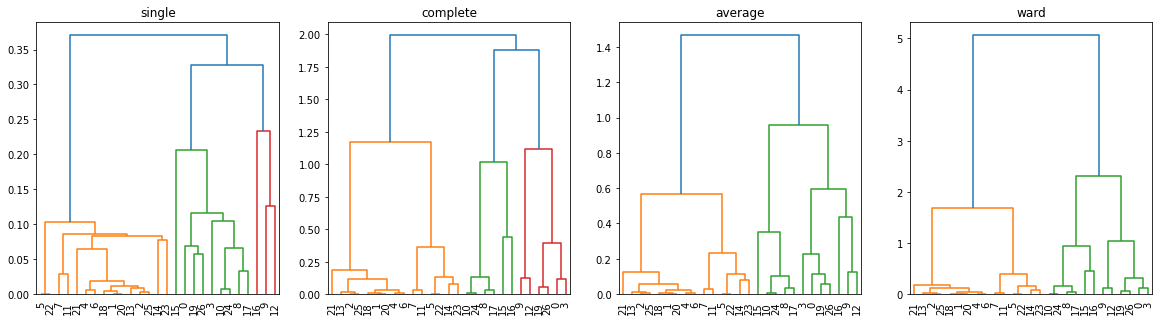

In [46]:
#2) Clustering using euclidean and cosine for distance matrix

dc1 = pdist(stock_scaled.values) #euclidean
dc2 = pdist(stock_scaled.values, metric='cosine')

#See now with linkage method and cosine distance matrix work
METHODS = ['single', 'complete', 'average', 'ward']

plt.figure(figsize=(20,5))

for i,m in enumerate(METHODS):
    plt.subplot(1,4,i+1)
    plt.title(m)
    dendrogram(linkage(dc2, method=m),
                leaf_rotation= 90)

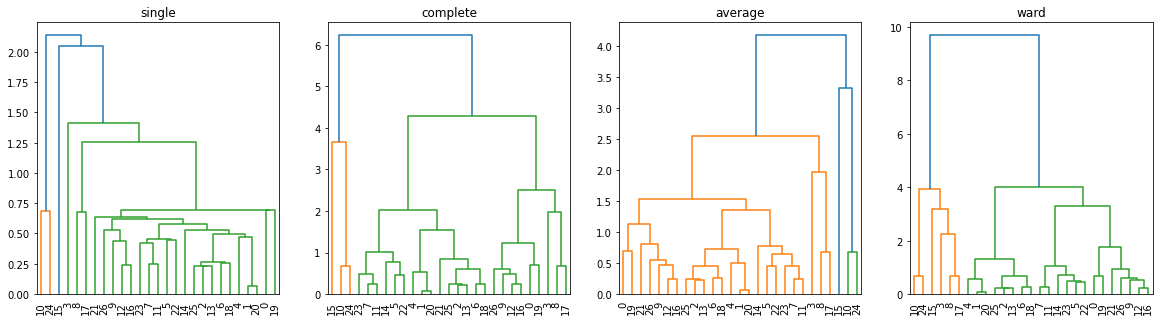

In [47]:
#3 ) See how linkage method and euclidean distance metric work
plt.figure(figsize=(20,5))

for i,m in enumerate(METHODS):
    plt.subplot(1,4,i+1)
    plt.title(m)
    dendrogram(linkage(dc1, method=m),
                leaf_rotation= 90)

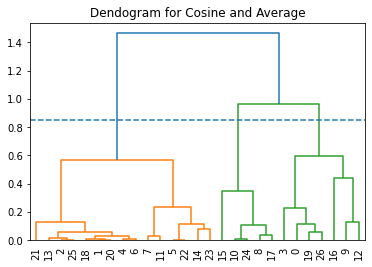

In [48]:
#4) Create the labels
hc1 = linkage(dc2, method='average')
plt.title('Dendogram for Cosine and Average')
dendrogram(hc1,
            leaf_rotation= 90)
plt.axhline(linestyle='--', y=.85)

In [49]:
labels = fcluster(hc1, 3, criterion='maxclust')
np.unique(labels)

array([1, 2, 3], dtype=int32)

In [50]:
#put the labels into the clean dataset
stocks_clean1['cluster'] = labels
stocks_clean1.head(3) #Review the dataset with the labels

,Company,GHG Scope 1,Total_Assets,Total_Sales,Utility,cluster
0,AES CORP (THE),66456.888889,37643.333333,14251.555556,1,3
9,ALLIANT ENERGY CORP,15811.300000,14436.700000,3427.600000,1,1
14,AMEREN CORP,29028.414286,24878.571429,6063.285714,1,1


In [51]:
#How many stocks per cluster
stocks_clean1.cluster.value_counts(dropna=False, sort=False)

1    15
2     5
3     7
Name: cluster, dtype: int64

## K-Means Clustering - Version 2 and utility industry

<AxesSubplot:>

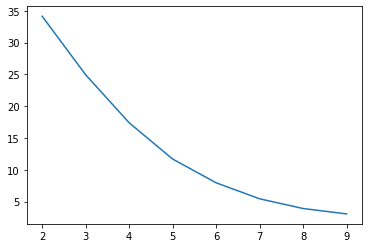

In [52]:
#Cluster Evaluation - Deciding how many clusters
X = stock_scaled.values
KRANGE = range(2,10)
sse = []

## loop over and evaluate
for k in KRANGE:
  km = KMeans(k)
  labs = km.fit_predict(stock_scaled)
  sse.append(km.inertia_)

#Elbow Method
sns.lineplot(KRANGE,sse)

<AxesSubplot:>

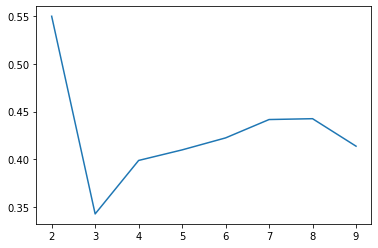

In [53]:
# Testing K
ss1 = []

for k in KRANGE:
  km = KMeans(k)
  lab = km.fit_predict(stock_scaled)
  ss1.append(metrics.silhouette_score(stock_scaled, lab))

sns.lineplot(KRANGE, ss1)

In [54]:
##K Means for 3
k3 = KMeans(3)
k3.fit(X)
k3_labs = k3.predict(X)

In [55]:
stocks_clean1['k3'] = k3_labs
stocks_clean1.k3.value_counts(dropna=False, sort=False) #

0    13
1     5
2     9
Name: k3, dtype: int64

We will proceed to export this utility dataset which will be used later on this notebook and in other ones. 

In [56]:
stocks_clean1.to_csv('/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/Utility_comp_clustering.csv', index=False)

### Hierarchical Clustering - Version 2 and energy industry

We follow the same steps as with version 2 and utility industry. 

1) Standarized data
2) Clustering using euclidean and cosine for distance matrix
3) Try different linkage method for each distance matrix
4) Create labels and add them to the original dataset
5) Sort by cluster values

In [57]:
# 1) Standarized the data
stocks_clean2 = stocks_cleaned[stocks_cleaned.Utility == 0]
stock_number = stocks_clean2.select_dtypes('number')
sc = StandardScaler()
stock_scaled = sc.fit_transform(stock_number)
stock_scaled = pd.DataFrame(stock_scaled, columns = stock_number.columns)
stock_scaled

,GHG Scope 1,Total_Assets,Total_Sales,Utility
0,-0.097826,-0.322949,-0.559181,0.0
1,-0.610522,-0.063158,-0.416030,0.0
2,-0.604975,-0.777642,-0.674909,0.0
3,1.647815,2.258538,1.715311,0.0
4,0.682291,0.900561,0.664007,0.0
5,-0.429168,-0.359049,-0.541567,0.0
6,-0.459472,-0.359508,-0.499440,0.0
7,3.858739,3.575635,3.667599,0.0
8,-0.463215,-0.439673,-0.387283,0.0
9,-0.455794,-0.379913,-0.429915,0.0


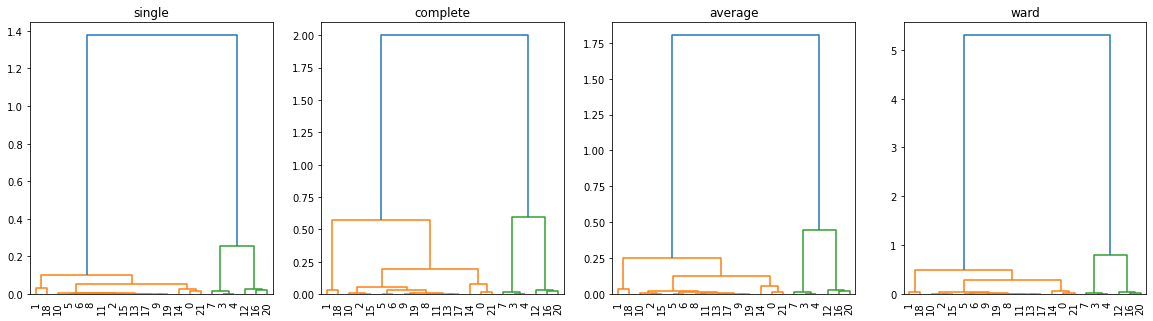

In [58]:
#2) Clustering using euclidean and cosine for distance matrix

dc1 = pdist(stock_scaled.values) #euclidean
dc2 = pdist(stock_scaled.values, metric='cosine')

#See now with linkage method and cosine distance matrix work
METHODS = ['single', 'complete', 'average', 'ward']

plt.figure(figsize=(20,5))

for i,m in enumerate(METHODS):
    plt.subplot(1,4,i+1)
    plt.title(m)
    dendrogram(linkage(dc2, method=m),
                leaf_rotation= 90)

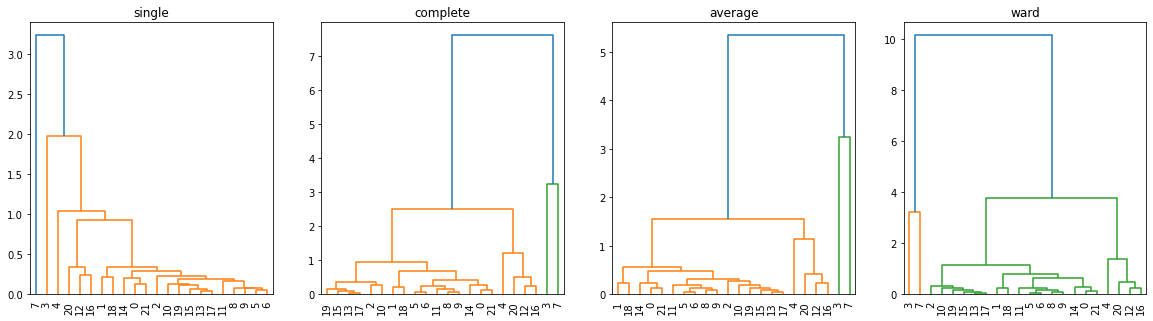

In [59]:
#3 ) See how linkage method and euclidean distance metric work
plt.figure(figsize=(20,5))

for i,m in enumerate(METHODS):
    plt.subplot(1,4,i+1)
    plt.title(m)
    dendrogram(linkage(dc1, method=m),
                leaf_rotation= 90)

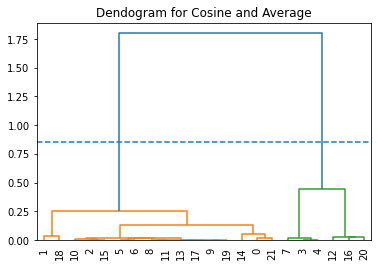

In [60]:
#4) Create the labels
hc1 = linkage(dc2, method='average')
plt.title('Dendogram for Cosine and Average')
dendrogram(hc1,
            leaf_rotation= 90)
plt.axhline(linestyle='--', y=.85)

In [61]:
labels = fcluster(hc1, 2, criterion='maxclust')
np.unique(labels)

array([1, 2], dtype=int32)

In [62]:
#put the labels into the clean dataset
stocks_clean2['cluster'] = labels
stocks_clean2.head(3) #Review the dataset with the labels

,Company,GHG Scope 1,Total_Assets,Total_Sales,Utility,cluster
37,APACHE CORP,14952.566667,36178.852333,10675.480500,0,1
49,BAKER HUGHES CO,373.166667,54286.000000,21324.666667,0,1
52,CABOT OIL & GAS CORP,530.900000,4487.245000,2066.277000,0,1


In [63]:
#How many stocks per cluster
stocks_clean2.cluster.value_counts(dropna=False, sort=False)

1    16
2     6
Name: cluster, dtype: int64

### K-means Clustering - Version 2 and energy industry

<AxesSubplot:>

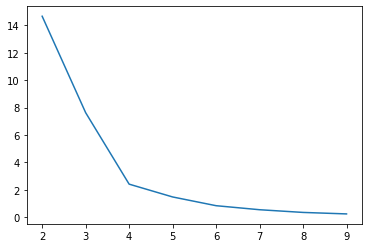

In [64]:
#Cluster Evaluation - Deciding how many clusters
X = stock_scaled.values
KRANGE = range(2,10)
sse = []

## loop over and evaluate
for k in KRANGE:
  km = KMeans(k)
  labs = km.fit_predict(stock_scaled)
  sse.append(km.inertia_)

#Elbow Method
sns.lineplot(KRANGE,sse)

<AxesSubplot:>

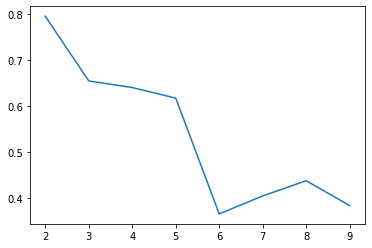

In [65]:
# Testing K
ss1 = []

for k in KRANGE:
  km = KMeans(k)
  lab = km.fit_predict(stock_scaled)
  ss1.append(metrics.silhouette_score(stock_scaled, lab))

sns.lineplot(KRANGE, ss1)


In [66]:
k3 = KMeans(3)
k3.fit(X)
k3_labs = k3.predict(X)

In [67]:
stocks_clean2['k3'] = k3_labs
stocks_clean2['k3'] = stocks_clean2['k3'] + 1
stocks_clean2.k3.value_counts(dropna=False, sort=False) #

1    16
2     1
3     5
Name: k3, dtype: int64

Not good at all.... We will proceed to export this utility dataset which will be used later on this notebook and in other ones. 

In [68]:
stocks_clean2.to_csv('/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/Energy_comp_clustering.csv', index=False)

## Cluster profiling for version 2 and utility industry

In [69]:
df_clus = stocks_clean1.drop(columns=['k3','Utility'])
stock_numeric = df_clus.select_dtypes('number')
stock_numeric

,GHG Scope 1,Total_Assets,Total_Sales,cluster
0,66456.888889,37643.333333,14251.555556,3
9,15811.300000,14436.700000,3427.600000,1
14,29028.414286,24878.571429,6063.285714,1
21,96828.785714,64374.571429,16056.042857,3
28,60.855556,15455.169667,2980.634000,1
53,5824.166667,28394.666667,10834.666667,1
70,12823.625000,24009.500000,6675.000000,1
88,3220.409091,44491.272727,12575.363636,1
110,41481.280000,77745.800000,13231.800000,2
115,35959.666667,30436.555556,11016.444444,3


In [70]:
clus_profile = stock_numeric.groupby("cluster").mean()
clus_profile

,GHG Scope 1,Total_Assets,Total_Sales
cluster,,,
1,14072.114399,29086.251791,7404.031962
2,60309.799460,98939.217071,20328.243838
3,54375.456363,40817.857028,12508.907826


<AxesSubplot:xlabel='cluster'>

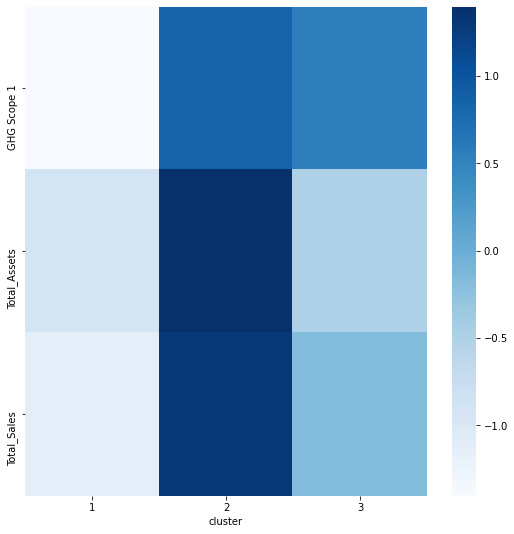

In [71]:
scp = StandardScaler()
cluster_scaled = scp.fit_transform(clus_profile)
cluster_scaled = pd.DataFrame(cluster_scaled, index=clus_profile.index, columns=clus_profile.columns)
plt.figure(figsize=(9,9))
sns.heatmap(cluster_scaled.T, cmap="Blues", center=0)

In [72]:
df_clus1 = stocks_clean1.drop(columns=['cluster','Utility'])
stock_numeric = df_clus1.select_dtypes('number')
stock_numeric

,GHG Scope 1,Total_Assets,Total_Sales,k3
0,66456.888889,37643.333333,14251.555556,0
9,15811.300000,14436.700000,3427.600000,2
14,29028.414286,24878.571429,6063.285714,2
21,96828.785714,64374.571429,16056.042857,1
28,60.855556,15455.169667,2980.634000,2
53,5824.166667,28394.666667,10834.666667,0
70,12823.625000,24009.500000,6675.000000,2
88,3220.409091,44491.272727,12575.363636,0
110,41481.280000,77745.800000,13231.800000,0
115,35959.666667,30436.555556,11016.444444,0


In [73]:
clus_profile = stock_numeric.groupby("k3").mean()
clus_profile

,GHG Scope 1,Total_Assets,Total_Sales
k3,,,
0,30102.041987,41761.448823,11487.493425
1,71379.300602,96264.971356,20893.092410
2,16115.095443,21387.907770,5162.352981


<AxesSubplot:xlabel='k3'>

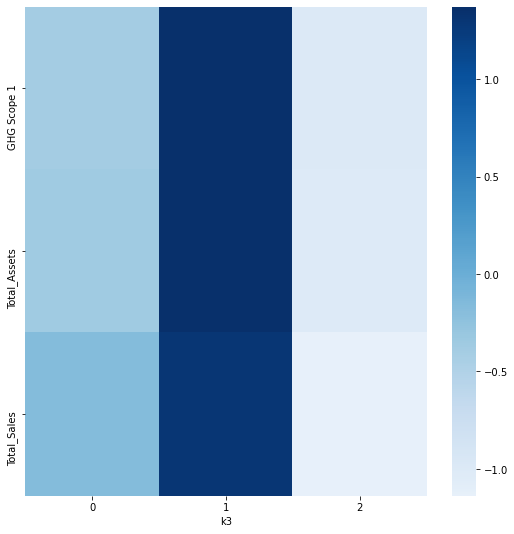

In [74]:
scp = StandardScaler()
cluster_scaled = scp.fit_transform(clus_profile)
cluster_scaled = pd.DataFrame(cluster_scaled, index=clus_profile.index, columns=clus_profile.columns)
plt.figure(figsize=(9,9))
sns.heatmap(cluster_scaled.T, cmap="Blues", center=0)

The heatmap presents how the clusters are grouped based in the features. Cluster #2 presents the high on average GHG Scope 1 and Cluster #3 presents the companies with the lower GHG Scope 1 on average. 


## Cluster profiling for version 2 and energy industry

Let's do the same thing for the companies in the energy industry

In [75]:
df_clus = stocks_clean2.drop(columns=['k3','Utility'])
stock_numeric = df_clus.select_dtypes('number')
stock_numeric

,GHG Scope 1,Total_Assets,Total_Sales,cluster
37,14952.566667,36178.852333,10675.480500,1
49,373.166667,54286.000000,21324.666667,1
52,530.900000,4487.245000,2066.277000,1
56,64592.857143,216105.857143,179877.785714,2
74,37136.521429,121456.214286,101670.000000,2
99,5530.263636,33662.727273,11985.818182,1
155,4668.533333,33630.720000,15119.670000,1
179,127464.285714,307906.142857,325111.000000,2
197,4562.100000,28043.285714,23463.142857,1
204,4773.108333,32208.500000,20291.750000,1


In [76]:
clus_profile = stock_numeric.groupby("cluster").mean()
clus_profile

,GHG Scope 1,Total_Assets,Total_Sales
cluster,,,
1,4984.578172,31384.022544,15947.468311
2,51733.944048,131498.835714,149143.447619


<AxesSubplot:xlabel='cluster'>

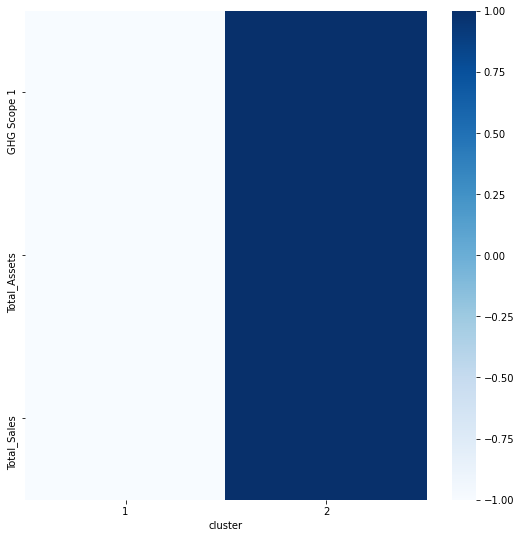

In [77]:
scp = StandardScaler()
cluster_scaled = scp.fit_transform(clus_profile)
cluster_scaled = pd.DataFrame(cluster_scaled, index=clus_profile.index, columns=clus_profile.columns)
plt.figure(figsize=(9,9))
sns.heatmap(cluster_scaled.T, cmap="Blues", center=0)

In [78]:
df_clus = stocks_clean2.drop(columns=['cluster','Utility'])
stock_numeric = df_clus.select_dtypes('number')
stock_numeric

,GHG Scope 1,Total_Assets,Total_Sales,k3
37,14952.566667,36178.852333,10675.480500,1
49,373.166667,54286.000000,21324.666667,1
52,530.900000,4487.245000,2066.277000,1
56,64592.857143,216105.857143,179877.785714,3
74,37136.521429,121456.214286,101670.000000,3
99,5530.263636,33662.727273,11985.818182,1
155,4668.533333,33630.720000,15119.670000,1
179,127464.285714,307906.142857,325111.000000,2
197,4562.100000,28043.285714,23463.142857,1
204,4773.108333,32208.500000,20291.750000,1


In [79]:
clus_profile = stock_numeric.groupby("k3").mean()
clus_profile

,GHG Scope 1,Total_Assets,Total_Sales
k3,,,
1,4984.578172,31384.022544,15947.468311
2,127464.285714,307906.142857,325111.000000
3,36587.875714,96217.374286,113949.937143


<AxesSubplot:xlabel='k3'>

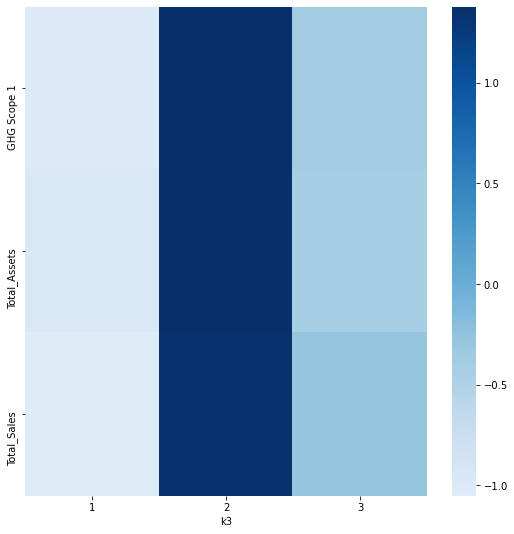

In [80]:
scp = StandardScaler()
cluster_scaled = scp.fit_transform(clus_profile)
cluster_scaled = pd.DataFrame(cluster_scaled, index=clus_profile.index, columns=clus_profile.columns)
plt.figure(figsize=(9,9))
sns.heatmap(cluster_scaled.T, cmap="Blues", center=0)

## Start creating classification score within industry


We came up with the following rules to build our classification model. 

- Create new column -> GHG Emissions
		○ Each cluster will represent a value from: Low, Medium, High 
- Three labels regarding the environmental actions
		○ Good Forecast
			- In the last 3 years:
                - GHG emissions are below the cluster average
                - The % change in GHG scope is descending
                - The Environmental Disclosure score higher than cluster average
		○ Improving
            - In the last 2 years:
                - GHG emissions are below the cluster average
                - The % change in GHG scope is descending
                - The Environmental Disclosure score higher than cluster average
		○ Deteriorating (Or bad)
            Else, then bad. 
            

### Utility Industry

We will start by assigning the labels to the companies in the utility industry. 

In [81]:
stocks_utility = pd.read_csv('/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/Utility_comp_clustering.csv')
stocks_utility.drop(columns='k3', inplace=True)
stocks_utility.head()

,Company,GHG Scope 1,Total_Assets,Total_Sales,Utility,cluster
0,AES CORP (THE),66456.888889,37643.333333,14251.555556,1,3
1,ALLIANT ENERGY CORP,15811.300000,14436.700000,3427.600000,1,1
2,AMEREN CORP,29028.414286,24878.571429,6063.285714,1,1
3,AMERICAN ELECTRIC POWER CO,96828.785714,64374.571429,16056.042857,1,3
4,AMERICAN WATER WORKS CO INC,60.855556,15455.169667,2980.634000,1,1


In [82]:
stocks_utility_num = stocks_utility.select_dtypes('number')
clus_profile = stocks_utility_num.groupby("cluster").mean().reset_index()
clus_profile.sort_values(by='GHG Scope 1')

,cluster,GHG Scope 1,Total_Assets,Total_Sales,Utility
0,1,14072.114399,29086.251791,7404.031962,1
2,3,54375.456363,40817.857028,12508.907826,1
1,2,60309.799460,98939.217071,20328.243838,1


<Figure size 720x360 with 0 Axes>

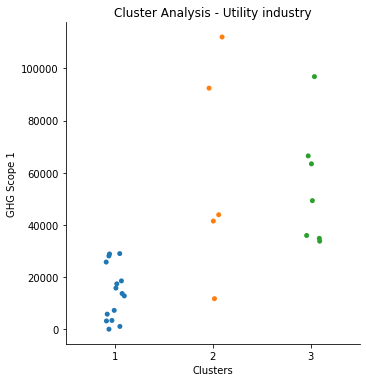

In [83]:
plt.figure(figsize=(10,5));
x = sns.catplot(x="cluster", y="GHG Scope 1", data=stocks_utility);
x.set(xlabel='Clusters', ylabel='GHG Scope 1', title = 'Cluster Analysis - Utility industry');

Below, we created a function to create the cluster label and return the dataset merged with the cluster label as a new column

In [84]:
def create_cluster_label(df, field):
    df_grouped = df.groupby(field).mean().reset_index()
    min_ghg = df_grouped['GHG Scope 1'].min()
    max_ghg = df_grouped['GHG Scope 1'].max()
    
    conditions = [(df_grouped['GHG Scope 1'] == min_ghg),
              (df_grouped['GHG Scope 1'] == max_ghg), 
               (df_grouped['GHG Scope 1'].between(left=min_ghg, right=max_ghg))]
    
    choices = ['Low', 'High','Medium']
    
    df_grouped['GHG_Emission_category'] = np.select(condlist=conditions, choicelist=choices)
    fields = []
    fields.append(field)
    fields.append('GHG_Emission_category')
    df_grouped = df_grouped[fields]
    df_merged = pd.merge(df, df_grouped, on=field)
    
    return df_merged

In [85]:
cluster_stocks = create_cluster_label(stocks_utility, 'cluster')
clus_profile1 = cluster_stocks[['cluster','GHG_Emission_category']]
clus_profile1

,cluster,GHG_Emission_category
0,3,Medium
1,3,Medium
2,3,Medium
3,3,Medium
4,3,Medium
5,3,Medium
6,3,Medium
7,1,Low
8,1,Low
9,1,Low


Next, we worked with two functions to implement the rules for the classification labels. 

In [86]:
def assignEnvironmentalScoreLabel(stocks, companies, cluster_stocks, clus_profile, field):
    company_label_score = {}
    for com in companies:
        data = stocks.loc[stocks.Company == com]
        clust_num = cluster_stocks.loc[cluster_stocks.Company == com,field].tolist()
        avg_ghg_scope = clus_profile[clus_profile[field] == clust_num[0]]['GHG Scope 1'].tolist()
        year_max = data.Year.max()
        year_min = year_max - 2
        
        assigned = checkMetrics(year_max, year_min, data, 'Good Forecast', company_label_score, com, avg_ghg_scope, companies)
        
        if assigned == False:
            year_min = year_max - 1
            data = stocks.loc[stocks.Company == com]
            assigned = checkMetrics(year_max, year_min, data, 'Improving', company_label_score, com, avg_ghg_scope, companies)
            if assigned == False:
                company_label_score[com] = 'Neutral'
    return company_label_score

In [87]:
def checkMetrics(maxYear, min_year, data, label, company_label_score, com, avg_ghg_scope, companies):
    success = False
    com_trend = data.loc[(data.Year <= maxYear) & (data.Year >= min_year), ['Year','Change_in_GHG','Environmental Disclosure Score','GHG Scope 1']]
    change_ghg = com_trend['Change_in_GHG'].tolist()
    res = all(abs(i) > abs(j) for i, j in zip(change_ghg, change_ghg[1:]))
    if res == True:
        ghg_scope = com_trend['GHG Scope 1'].tolist()
        res_ghg = all(i < avg_ghg_scope[0] for i in ghg_scope)
        if res_ghg == True:
            eds_list = com_trend['Environmental Disclosure Score'].tolist()
            eds = stocks.loc[(stocks.Company.isin(companies))&(stocks.Year <= maxYear) & 
                             (stocks.Year >= min_year),['Environmental Disclosure Score']].mean().tolist()
            res_eds = all(i < eds[0] for i in eds_list)
            if res_eds == True:
                company_label_score[com] = label
                success = True
    return success

In [88]:
companies = cluster_stocks.Company.tolist()
my_dict = assignEnvironmentalScoreLabel(stocks, companies, cluster_stocks, clus_profile, 'cluster')

In [89]:
df_com_utility = pd.DataFrame.from_dict(my_dict, orient='index', columns=['Classification'])
df_com_utility = df_com_utility.reset_index()
df_com_utility.rename(columns = {'index':'Company'}, inplace=True)
df_com_utility.head()

,Company,Classification
0,AES CORP (THE),Neutral
1,AMERICAN ELECTRIC POWER CO,Neutral
2,DTE ENERGY CO,Neutral
3,ENTERGY CORP,Improving
4,FIRSTENERGY CORP,Neutral


In [90]:
df_utility = pd.merge(cluster_stocks, df_com_utility, on='Company')
df_utility.head()

,Company,GHG Scope 1,Total_Assets,Total_Sales,Utility,cluster,GHG_Emission_category,Classification
0,AES CORP (THE),66456.888889,37643.333333,14251.555556,1,3,Medium,Neutral
1,AMERICAN ELECTRIC POWER CO,96828.785714,64374.571429,16056.042857,1,3,Medium,Neutral
2,DTE ENERGY CO,35959.666667,30436.555556,11016.444444,1,3,Medium,Neutral
3,ENTERGY CORP,33786.523077,42877.418154,11349.992538,1,3,Medium,Improving
4,FIRSTENERGY CORP,34874.625000,41942.250000,12717.500000,1,3,Medium,Neutral


Above we can see the companies in the utility industry and their respective Classification. We will proceed to export the dataframe to continue the analysis in another notebook. 

In [91]:
df_utility.to_csv('/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/UtilityClassification.csv', index=False)

### Energy Industry

We are going to follow the same 'rules' applied to the utility industry. Also, even thought the clusters have a few observation each, we decided to continue with 3 clusters to be able to assign Low, Medium and High labels.

Eventually, the model could receive more information and the clustering values will get distributed better. 

In [94]:
stocks_energy = pd.read_csv('/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/Energy_comp_clustering.csv')
stocks_energy.drop(columns='cluster', inplace=True)
stocks_energy.head()

,Company,GHG Scope 1,Total_Assets,Total_Sales,Utility,k3
0,APACHE CORP,14952.566667,36178.852333,10675.480500,0,1
1,BAKER HUGHES CO,373.166667,54286.000000,21324.666667,0,1
2,CABOT OIL & GAS CORP,530.900000,4487.245000,2066.277000,0,1
3,CHEVRON CORP,64592.857143,216105.857143,179877.785714,0,3
4,CONOCOPHILLIPS,37136.521429,121456.214286,101670.000000,0,3


In [95]:
stocks_energy_num = stocks_energy.select_dtypes('number')
clus_profile_energy = stocks_energy_num.groupby("k3").mean().reset_index()
clus_profile_energy.sort_values(by='GHG Scope 1')

,k3,GHG Scope 1,Total_Assets,Total_Sales,Utility
0,1,4984.578172,31384.022544,15947.468311,0
2,3,36587.875714,96217.374286,113949.937143,0
1,2,127464.285714,307906.142857,325111.000000,0


<Figure size 720x2160 with 0 Axes>

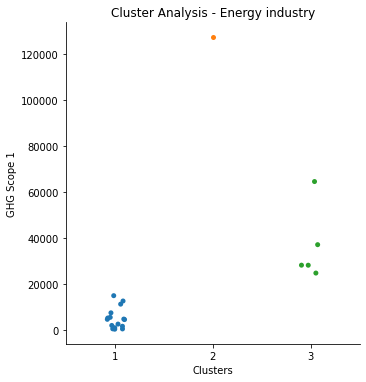

In [105]:
plt.figure(figsize=(10,30));
y = sns.catplot(x="k3", y="GHG Scope 1", data=stocks_energy);
y.set(xlabel='Clusters', ylabel='GHG Scope 1', title = 'Cluster Analysis - Energy industry');

In [97]:
cluster_stocks = create_cluster_label(stocks_energy, 'k3')
clus_profile1 = cluster_stocks[['k3','GHG_Emission_category']]
clus_profile1

,k3,GHG_Emission_category
0,1,Low
1,1,Low
2,1,Low
3,1,Low
4,1,Low
5,1,Low
6,1,Low
7,1,Low
8,1,Low
9,1,Low


In [98]:
companies = cluster_stocks.Company.tolist()
dict_energy = assignEnvironmentalScoreLabel(stocks, companies, cluster_stocks, clus_profile_energy, 'k3')

In [99]:
df_com_energy = pd.DataFrame.from_dict(dict_energy, orient='index', columns=['Classification'])
df_com_energy = df_com_energy.reset_index()
df_com_energy.rename(columns = {'index':'Company'}, inplace=True)
df_com_energy.head()

,Company,Classification
0,APACHE CORP,Neutral
1,BAKER HUGHES CO,Neutral
2,CABOT OIL & GAS CORP,Neutral
3,DEVON ENERGY CORP,Neutral
4,EOG RESOURCES INC,Neutral


In [100]:
df_energy = pd.merge(cluster_stocks, df_com_energy, on='Company')
df_energy.head()

,Company,GHG Scope 1,Total_Assets,Total_Sales,Utility,k3,GHG_Emission_category,Classification
0,APACHE CORP,14952.566667,36178.852333,10675.480500,0,1,Low,Neutral
1,BAKER HUGHES CO,373.166667,54286.000000,21324.666667,0,1,Low,Neutral
2,CABOT OIL & GAS CORP,530.900000,4487.245000,2066.277000,0,1,Low,Neutral
3,DEVON ENERGY CORP,5530.263636,33662.727273,11985.818182,0,1,Low,Neutral
4,EOG RESOURCES INC,4668.533333,33630.720000,15119.670000,0,1,Low,Neutral


Above we can see the companies in the energy industry and their respective classification. We will proceed to export the dataframe to continue the analysis in another notebook. 

In [101]:
df_energy.to_csv('/Users/maralinetorres/Documents/GitHub/Predicting-Environmental-and-Social-Actions/Datasets/EnergyClassification.csv', index=False)

## Conclusion

We concluded every step to build our own classification model. As expected with every new model, it is necessary to keep tuning and training this classification so it presents betters results. We are confident about the initial steps done to have at least an idea of what is possible. Next steps would be to add more companies for each industry or even keep building new models for other industries.

Moreover, as year pass by and we keep adding more past data, the classification will get updated too and present insightful information to Perpetual Investors.


## Next steps


Now, we want to present the classification results in a more friendly and interpretable manner. Therefore, we decided to build a small application using Streamlit to present a dashboard with the results. To see the code related to this application, please refer to the python script **classification_app.py**